# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')

In [4]:
azdias.CAMEO_DEU_2015.unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
print('Number of Nan fields: {}/{}'.format(np.sum((np.asmatrix(azdias.isna()))),azdias.shape[0]*azdias.shape[1]))
print('Number of rows with NaN values in at least one column: {}/{}'.format(int(sum(np.sum(np.asmatrix(azdias.isna()),axis=1) > 0)),azdias.shape[0]))

Number of Nan fields: 4896838/75753785
Number of rows with NaN values in at least one column: 628074/891221


In [3]:
# Parse the string into a list of invalid values
feat_info.missing_or_unknown = feat_info.missing_or_unknown.map(lambda x: x[1:-1].split(','))

In [4]:
# Creating a dictionary that maps column names to invalid values
invalidmappingD = feat_info[['attribute','missing_or_unknown']].set_index('attribute').to_dict()['missing_or_unknown']
# x.name represents the column name. x is the column in the dataframe and we check whether each value in the column 
# is included in the list of invalid values. This results in a dataframe with True for all those positions that were invalid
result =azdias.apply(lambda x:x.isin(invalidmappingD[x.name]),result_type='broadcast')

In [9]:
print('Number of Invalid fields: {}/{}'.format(np.sum(np.asmatrix(result)),azdias.shape[0]*azdias.shape[1]))
print('Number of rows with invalid values in at least one column: {}/{}'.format(int(sum(np.sum(np.asmatrix(result),axis=1) > 0)),result.shape[0]))

Number of Invalid fields: 3477091/75753785
Number of rows with invalid values in at least one column: 890934/891221


In [5]:
# Now, because some invalid values are not numbers, we need to do a bit of processing in the dictionary
# so we cast to integers all those values that are numbers. Otherwise we leave them as string type
invalidmappingCasted = {}
for key,values in invalidmappingD.items():
    new_values = []
    for v in values:
        try:
            new_values.append(int(v))
        except ValueError:
            if v != '':
                new_values.append(v)
    invalidmappingCasted[key] = new_values

In [6]:
# We make use of replace to replace all those invalid values in the column for np.nans so azdias_clean
# is the dataframe that we were asked to produce
azdias_clean =azdias.apply(lambda x: x.replace({i:np.nan for i in invalidmappingCasted[x.name]}),result_type='broadcast')
azdias_clean.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2,1,2,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1,2,5,1,5,2,5,4,5,...,2,3,2,1,1,5,4,3,5,4
2,NaN,3,2,3,1,4,1,2,3,5,...,3,3,1,0,1,4,4,3,5,2
3,2,4,2,2,4,2,5,2,1,2,...,2,2,2,0,1,3,4,2,3,3
4,NaN,3,1,5,4,3,4,1,3,2,...,2,4,2,1,2,3,3,4,6,5


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# This is the amount of missing information per feature in the dataframe
azdias_clean.isna().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

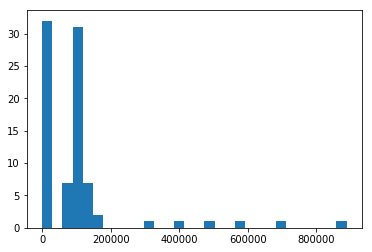

In [13]:
# Investigate patterns in the amount of missing data in each column.
# The histogram below clearly displays that the majority of columns contain missing information for some individuals
# We can regard all those features missing information for more than 200k individuals to be outliers
plt.hist(azdias_clean.isna().sum(),bins=30);

In [9]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# To remove the outliers first we find the features that contain more than 200k missing values, and then drop those features
# from the dataset using drop and a list comprehension
indexes = azdias_clean.isna().sum() > 200000
indexes = indexes[indexes==True].index
print(indexes)
azdias_clean_2 = azdias_clean.drop(columns =[c for c in azdias_clean.columns if c in indexes])

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


#### Discussion 1.1.2: Assess Missing Data in Each Column

Interestingly, there is a similar amount of data truly missing in the dataset compared to data that contains invalid information.
Also, it seems that most rows or individuals in the dataframe are missing information for some feature.
Following instructions all invalid cells were replaced by np.nan and so after this there is no difference between those values that were not included or those that contained invalid values (both are np.nan now).    

The histogram that we were asked to produce, reveals that there are more columns with missing values than columns with all valid values. However, it seems clear that features that are missing more than 200k individuals are outliers.
Hence, it was decided to drop all those columns that contained missing information for more than 200k individuals, that amounts to 6 columns only.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

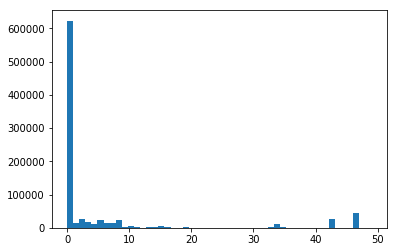

In [15]:
# How much data is missing in each row of the dataset?

# In this case, it seems that most individuals are missing very little information. In other words most individuals
# contain information for practically all features, However there are a few outliers that we can regard those individuals
# that are missing information for more than 10 features
plt.hist(azdias_clean_2.isna().sum(axis=1),bins=50);

In [10]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# We split the dataframe between those individuals that are missing more and less than 10 features
setLowMissing = azdias_clean_2[azdias_clean_2.isna().sum(axis=1) <= 10]
setHighMissing= azdias_clean_2[azdias_clean_2.isna().sum(axis=1) > 10]
setLowMissing.shape, setHighMissing.shape

((780153, 79), (111068, 79))

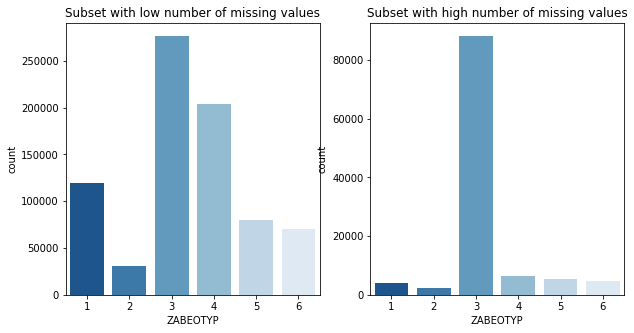

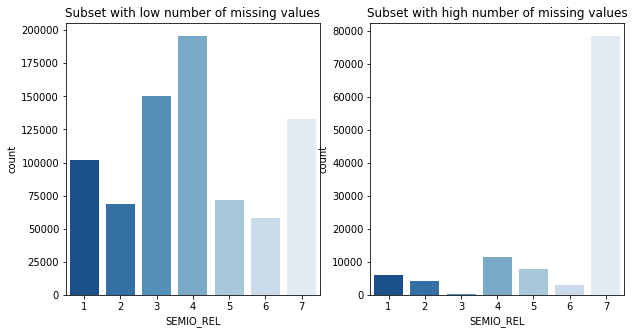

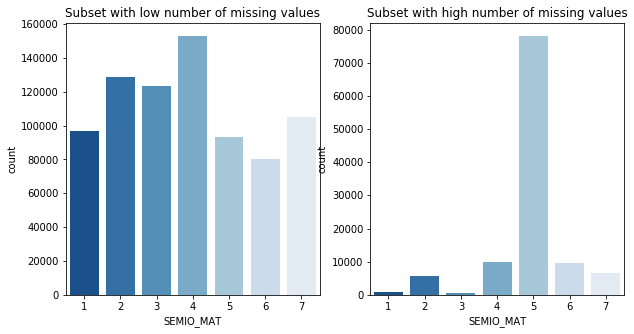

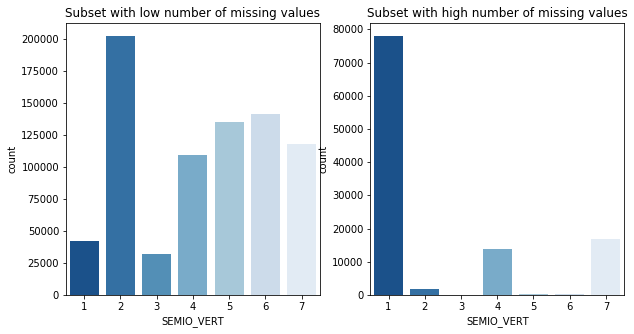

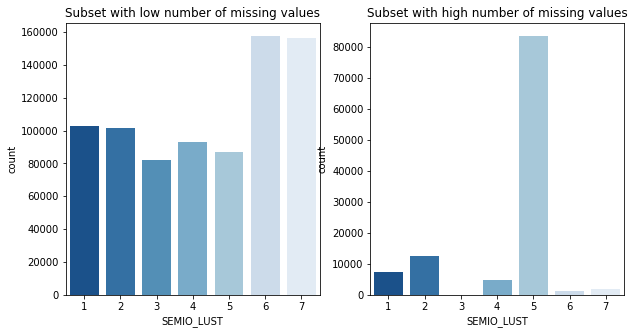

In [14]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def plotcompare(low,high,col):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.countplot(low[col],palette='Blues_r')
    plt.title('Subset with low number of missing values')
    plt.subplot(1,2,2)
    sns.countplot(high[col],palette='Blues_r')
    plt.title('Subset with high number of missing values')

# Using the helper function above we can display the distribution of values for a few rows for both subset dataframes.
# It can be clearly seen that the distributions are drastically different and so it will be decided to drop all those individuals
# with more than 10 features missing
columnsordered = azdias_clean_2.isna().sum().sort_values().index
for i in range(5):
    plotcompare(setLowMissing,setHighMissing,columnsordered[i])

In [18]:
# From first assignment review
from scipy.stats import ks_2samp
comp_df = pd.DataFrame(azdias_clean_2.columns, columns=['col'])
def hypothesis_test(df1, df2, cols):
    stats = []
    pvalues = []
    for col in cols:
        counts_main = df1[col].value_counts().sort_index()
        counts_drop = df2[col].value_counts().sort_index()
        try:
            ch = ks_2samp(counts_main, counts_drop)
            stats.append(ch.statistic)
            pvalues.append(ch.pvalue)
        except:
            stats.append(np.nan)
            pvalues.append(np.nan)

    return stats, pvalues

stats, pvalues = hypothesis_test(setLowMissing, setHighMissing, setLowMissing.columns.values)
comp_df['stats'] = stats
comp_df['pvalues'] = pvalues
comp_df[comp_df['col'].isin(columnsordered[:5])]

,col,stats,pvalues
24,SEMIO_REL,0.857143,0.004171
25,SEMIO_MAT,1.000000,0.000449
26,SEMIO_VERT,0.857143,0.004171
27,SEMIO_LUST,0.857143,0.004171
39,ZABEOTYP,0.833333,0.012238


In [19]:
# Drop all those individuals that contain missing values for more than 10 features.
# Basically, all outlier individuals are removed from the analysis from now. No need to cluster those independently as 
# they won't count from now onwards
azdias_clean = setLowMissing

#### Discussion 1.1.3: Assess Missing Data in Each Row

After dropping certain features from the dataframe and following instructions a hist plot was produced. This plot shows that the great majority of individuals have none or very few features missing. 
Again it was decided based on the plot that 10 features was probably the threshold to consider a particular individual to be an outlier. 
Following advise, the dataframe was split in two groups, one that contained rows with less than 10 empty features, and one with more than 10.
The plots that were displayed show that distributions for these two datasets are very different for all features analysed, and the conclusion was to drop all those individuals that had more than 10 features missing

Also, as suggested by the first reviewer a Kolmogorov-Smirnov test was carried out on the dataset to find out whether the two subsets had features that followed similar distributions. The p-values above are very low for the features that contain very little missing data, what seems to suggest that the subset with few missing values and the subset with high missing values do not seem to represent similar distrubutions. Therefore another good argument to remove those entries with more than 10 missing features

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?
print(feat_info.type.value_counts())
print(feat_info.type.value_counts().sum())

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64
85


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Making use of feat_info dataframe, extract the names of all features that are of type 'categorical'
categoricalColumns = [col for col in feat_info[feat_info['type'] == 'categorical'].attribute.values if col not in indexes]
subsetcat = azdias_clean[categoricalColumns]
subsetcat.head()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2,5,1,10,0,5,3,2,1,1,3,1,2,5,8,W,8,8A
2,2,3,1,10,1,1,1,3,2,1,2,0,1,5,1,W,4,4C
3,2,2,6,1,0,NaN,NaN,9,4,1,1,0,1,3,1,W,2,2A
4,1,5,5,5,0,10,5,3,2,1,2,0,2,4,1,W,6,6B
5,2,2,2,1,0,1,1,4,2,1,0,0,2,4,1,W,8,8C


In [26]:
# Now for all categorical features, subdivide them into binary categorical or multilevel categorical.
# Also print them to identify which binary feature needs re-encoding ('OST_WEST_KZ').

binary_cat = {}
multilevel_cat = {}
for column in subsetcat.columns:
    if len(subsetcat[column].value_counts()) == 2:
        binary_cat[column] = list(subsetcat[column].value_counts().index)
    else:
        multilevel_cat[column] = list(subsetcat[column].value_counts().index)
print(binary_cat)
print('\n')
print(multilevel_cat)

{'ANREDE_KZ': [2, 1], 'GREEN_AVANTGARDE': [0, 1], 'SOHO_KZ': [0.0, 1.0], 'VERS_TYP': [2.0, 1.0], 'OST_WEST_KZ': ['W', 'O']}


{'CJT_GESAMTTYP': [4.0, 3.0, 2.0, 5.0, 6.0, 1.0], 'FINANZTYP': [6, 1, 5, 2, 4, 3], 'GFK_URLAUBERTYP': [12.0, 10.0, 8.0, 11.0, 5.0, 4.0, 9.0, 3.0, 1.0, 7.0, 2.0, 6.0], 'LP_FAMILIE_FEIN': [1.0, 10.0, 2.0, 11.0, 8.0, 7.0, 4.0, 5.0, 9.0, 6.0, 3.0], 'LP_FAMILIE_GROB': [1.0, 5.0, 2.0, 4.0, 3.0], 'LP_STATUS_FEIN': [1.0, 9.0, 2.0, 10.0, 4.0, 3.0, 6.0, 5.0, 8.0, 7.0], 'LP_STATUS_GROB': [1.0, 2.0, 4.0, 5.0, 3.0], 'NATIONALITAET_KZ': [1.0, 2.0, 3.0], 'SHOPPER_TYP': [1.0, 2.0, 3.0, 0.0], 'ZABEOTYP': [3, 4, 1, 5, 6, 2], 'GEBAEUDETYP': [1.0, 3.0, 8.0, 2.0, 4.0, 6.0, 5.0], 'CAMEO_DEUG_2015': ['8', '9', '6', '4', '3', '2', '7', '5', '1'], 'CAMEO_DEU_2015': ['6B', '8A', '4C', '2D', '3C', '7A', '3D', '8B', '4A', '8C', '9D', '9B', '9C', '7B', '9A', '2C', '8D', '6E', '2B', '5D', '6C', '2A', '1D', '5A', '1A', '5B', '5C', '7C', '4B', '3A', '4D', '3B', '6A', '9E', '6D', '6F', '7D', '4

In [27]:
# Re-encode categorical variable(s) to be kept in the analysis.
# As said before, re-econde the binary with string type values.
# Also, select a few multilevel features as they have been chosen for one hot encoder.
# Instead of using sklearn for one hot encoder we will use pandas get_dummies method.
azdias_clean['OST_WEST_KZ'] = azdias_clean['OST_WEST_KZ'].replace({'W':0,'O':1})
onehotencoderlist = ['FINANZTYP','SHOPPER_TYP','NATIONALITAET_KZ']
azdias_clean = pd.get_dummies(azdias_clean,columns=onehotencoderlist)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [28]:
# Drop all those multilevel categorical that have not been one-hot-encoded. Not all have been encoded as they will add many
# more features into the dataframe and will cluter the whole analysis
listnottodrop = onehotencoderlist + ['OST_WEST_KZ']
listtodrop = [col for col in multilevel_cat if col not in listnottodrop]
azdias_clean.drop(columns=listtodrop,inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

First all categorical values were listed and split into two groups, namely binary and non-binary categorical variables. Then for binary the non-numerical variable was identified an re-encoded. For multilevel categorical a few of them were selected for further encoding and the majority were dropped.
The reasoning behind this decision is to take some multilevel categorical variables that will not add many more features when dummy-encoding them. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Two dictioanries have been created to help engineer two new features. I think they don't require further explanation as they
# very clear when reading the information above
mapDictionaryDecade = {1:0,2:0,3:1,4:1,5:2,6:2,7:2,8:3,9:3,10:4,11:4,12:4,13:4,14:5,14:5}
mapDictionaryType = {1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,14:1} # 0 - mainstream, 1 - avantgarde
azdias_clean['NewDecadeBorn'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].map(mapDictionaryDecade)
azdias_clean['NewPersonType'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].map(mapDictionaryType)
# Once the features have been engineered, we delete the original feature
azdias_clean.drop(columns=['PRAEGENDE_JUGENDJAHRE'],inplace=True)

- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement

In [30]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Performing a similar action on CAMEO_INTL_2015 feature
# In this case instead of using dictionaries the split operation can be easily done with division and modulo operations
azdias_clean['CAMEO_INTL_2015'] = azdias_clean['CAMEO_INTL_2015'].astype('float')
azdias_clean['CAMEO_INTL_2015_Income']=azdias_clean['CAMEO_INTL_2015'].map(lambda x: np.floor(x/10))
azdias_clean['CAMEO_INTL_2015_AgeGroup']=azdias_clean['CAMEO_INTL_2015'].map(lambda x: np.floor(x%10))
azdias_clean.drop(columns=['CAMEO_INTL_2015'],inplace=True)

### 3.7. WOHNLAGE
Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood

In [36]:
# As suggested in the review, wohnlage will be engineered as well. Basically, the first 5 relate to non rural, the last
# two indicate rural neighborhood
azdias_clean['rural'] = azdias_clean['WOHNLAGE'].map(lambda x: x if x in [7,8] else np.nan)
azdias_clean['nonrural'] = azdias_clean['WOHNLAGE'].map(lambda x: x if x not in [7,8] else np.nan)
azdias_clean.drop(columns=['WOHNLAGE'],inplace=True)

In [37]:
# No more mixed features will be engineered, so remove the rest, including
mixedColumns = [col for col in feat_info[feat_info['type'] == 'mixed'].attribute.values if col not in indexes]
azdias_clean.drop(columns= [col for col in mixedColumns if col not in ['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE','WOHNLAGE']], inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Both "mixed" features that I was asked to analyse were further explained in a separate file. An excerpt was copied into the notebook for reference. Various dictionaries were used to help me engineer two separate features for each of the "mixed" features we were asked to engineer.
Finally, all other mixed features were identified and dropped from the dataframe. The only reason why it was decided to drop them was to keep the analysis simpler

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [27]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [28]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
columns = pd.DataFrame(data={'columns':azdias_clean.columns})
df =columns.merge(right=feat_info,how='inner',left_on='columns',right_on='attribute')[['attribute','type']]
df.type.value_counts()

ordinal        49
numeric         6
categorical     5
Name: type, dtype: int64

In [29]:
azdias_clean[df[df['type']=='numeric'].attribute].head()

,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW
1,2,0,11,0,1992,963
2,1,0,10,0,1992,712
3,0,0,1,0,1997,596
4,4,0,3,0,1992,435
5,1,0,5,0,1992,1300


In [30]:
azdias_clean[df[df['type']=='categorical'].attribute].head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,2,0,1,2,0
2,2,1,0,1,0
3,2,0,0,1,0
4,1,0,0,2,0
5,2,0,0,2,0


In [31]:
azdias_clean.iloc[:,-17:].head()

,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,NewDecadeBorn,NewPersonType,CAMEO_INTL_2015_Income,CAMEO_INTL_2015_AgeGroup
1,1,0,0,0,0,0,0,0,0,1,1,0,0,5.0,1.0,5.0,1.0
2,1,0,0,0,0,0,0,0,1,0,1,0,0,NaN,NaN,2.0,4.0
3,0,0,0,0,0,1,0,1,0,0,1,0,0,3.0,0.0,1.0,2.0
4,0,0,0,0,1,0,0,0,1,0,1,0,0,3.0,0.0,4.0,3.0
5,0,1,0,0,0,0,1,0,0,0,1,0,0,1.0,0.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [38]:
def clean_data(df,featinfo,indexes):
    featinfo.missing_or_unknown = featinfo.missing_or_unknown.map(lambda x: x[1:-1].split(','))
    # Creating a dictionary that maps column names to invalid values
    invalidmappingD = featinfo[['attribute','missing_or_unknown']].set_index('attribute').to_dict()['missing_or_unknown']
    invalidmappingCasted = {}
    for key,values in invalidmappingD.items():
        new_values = []
        for v in values:
            try:
                new_values.append(int(v))
            except ValueError:
                if v != '':
                    new_values.append(v)
        invalidmappingCasted[key] = new_values
    df =df.apply(lambda x: x.replace({i:np.nan for i in invalidmappingCasted[x.name]}),result_type='broadcast')
    df = df.drop(columns =[c for c in df.columns if c in indexes])
    setLowMissing = df[df.isna().sum(axis=1) <= 10]
    df = setLowMissing
    # 1.2.1
    categoricalColumns = [col for col in featinfo[featinfo['type'] == 'categorical'].attribute.values if col not in indexes]
    subsetcat = df[categoricalColumns]
    binary_cat = {}
    multilevel_cat = {}
    for column in subsetcat.columns:
        if len(subsetcat[column].value_counts()) == 2:
            binary_cat[column] = list(subsetcat[column].value_counts().index)
        else:
            multilevel_cat[column] = list(subsetcat[column].value_counts().index)
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'W':0,'O':1})
    onehotencoderlist = ['FINANZTYP','SHOPPER_TYP','NATIONALITAET_KZ']
    df = pd.get_dummies(df,columns=onehotencoderlist)
    listnottodrop = onehotencoderlist + ['OST_WEST_KZ']
    listtodrop = [col for col in multilevel_cat if col not in listnottodrop]
    print(listtodrop)
    df.drop(columns=listtodrop,inplace=True)
    #1.2.2
    mapDictionaryDecade = {1:0,2:0,3:1,4:1,5:2,6:2,7:2,8:3,9:3,10:4,11:4,12:4,13:4,14:5,14:5}
    mapDictionaryType = {1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,14:1} # 0 - mainstream, 1 - avantgarde
    df['NewDecadeBorn'] = df['PRAEGENDE_JUGENDJAHRE'].map(mapDictionaryDecade)
    df['NewPersonType'] = df['PRAEGENDE_JUGENDJAHRE'].map(mapDictionaryType)
    df.drop(columns=['PRAEGENDE_JUGENDJAHRE'],inplace=True)	
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype('float')
    df['CAMEO_INTL_2015_Income']=df['CAMEO_INTL_2015'].map(lambda x: np.floor(x/10))
    df['CAMEO_INTL_2015_AgeGroup']=df['CAMEO_INTL_2015'].map(lambda x: np.floor(x%10))
    df.drop(columns=['CAMEO_INTL_2015'],inplace=True)
    df['rural'] = df['WOHNLAGE'].map(lambda x: x if x in [7,8] else np.nan)
    df['nonrural'] = df['WOHNLAGE'].map(lambda x: x if x not in [7,8] else np.nan)
    df.drop(columns=['WOHNLAGE'],inplace=True)    
    mixedColumns = [col for col in featinfo[featinfo['type'] == 'mixed'].attribute.values if col not in indexes]
    df.drop(columns= [col for col in mixedColumns if col not in ['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE','WOHNLAGE']], inplace=True)
    #2.1
    probabilitybag = df[(df.isna().sum() > 0).index]
    for col in probabilitybag.columns:
        bagofvalues = df[df[col].notnull()][col].values
        missingindexes = df[df[col].isna()].index
        valuestoreplace = np.random.choice(bagofvalues,len(missingindexes),replace=True)
        df.loc[missingindexes,col] = valuestoreplace
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [39]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# As explained a bit later, instead of chosing the same value to fill in for all those np.nan cells, we have decided to fill
# all those missing cells with values from the feature population following the same distributions. Therefore we create a 
# sort of bootstrap sample
print('Num Columns with missing values: {}, total num columns: {}'.format((azdias_clean.isna().sum() > 0).sum(),azdias_clean.shape[1]))
# Create the bag of values to draw from
probabilitybag = azdias_clean[(azdias_clean.isna().sum() > 0).index]
for col in probabilitybag.columns:
    bagofvalues = azdias_clean[azdias_clean[col].notnull()][col].values
    missingindexes = azdias_clean[azdias_clean[col].isna()].index
    # use random choice to get a value with the probability present in the dataframe
    valuestoreplace = np.random.choice(bagofvalues,len(missingindexes),replace=True)
    # replace np.nan values for the values drawn from the bag
    azdias_clean.loc[missingindexes,col] = valuestoreplace

Num Columns with missing values: 37, total num columns: 79


In [34]:
print('Num Columns with missing values: {}, total num columns: {}'.format((azdias_clean.isna().sum() > 0).sum(),azdias_clean.shape[1]))

Num Columns with missing values: 0, total num columns: 77


In [40]:
# Apply feature scaling to the general population demographics data.
# Very easy step using sklearn standard scaler. Scaler will be used later on with customer's data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_clean)

### Discussion 2.1: Apply Feature Scaling

There were still missing values in the dataframe. Various algorithms that will be used in this study rely on the dataframe to be completely gap free and so there were a few options to chose from. The easiest would have been to remove all those individuals that contained at least one feature that was missing. However that would have required me to remove a great proportion of the dataset. The second solution would have been to fill all the missing values for a given feature with the same value. To me, this makes the dataset distorted because it changes the feature's stats. I've decided to assign values to the missing fields in the same proportion as they are in the feature itself. So for example if a multilevel categorical data contains value 1 20% of the time, 2 60% of the time and 3 20% of the time, then the idea would be to fill in the missing entries with the same probability distribution. And that was the approach taken above
Feature scaling was performed using StandarScaler utility from sklearn

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [41]:
# Apply PCA to the data.
mypca = PCA()
azdias_pcaed = mypca.fit_transform(azdias_scaled)

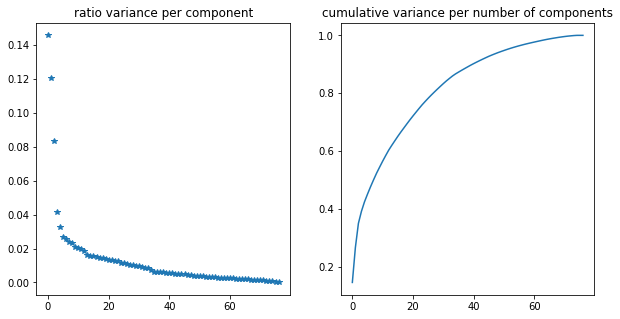

In [37]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('ratio variance per component')
plt.plot(mypca.explained_variance_ratio_,'*')
plt.subplot(1,2,2)
plt.title('cumulative variance per number of components')
plt.plot(mypca.explained_variance_ratio_.cumsum())

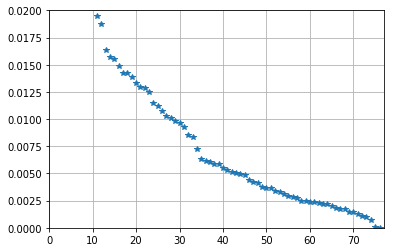

In [38]:
plt.plot(mypca.explained_variance_ratio_,'*')
plt.axis([0,len(mypca.explained_variance_ratio_), 0, 0.02]);
plt.grid()

In [42]:
# Re-apply PCA to the data while selecting for number of components to retain.
# 26 compoennts chosen as after the 26 each principal component explains less than 1% of variance in the original dataframe
mypca = PCA(n_components=26)
azdias_pcaed = mypca.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

The curves represented above look in line with what was studied over the lessons. The main principal components carry most of the variance for the dataset and so they are the components that we will like to retain. It was not clear cut to me how many components would be good enough. I guess this goes hand in hand with experience and so it may be clearer to me after a few projects. Having said that, I took all those components that contributed more than 1% towards explaining dataset variance. That amount to approx 26 components

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

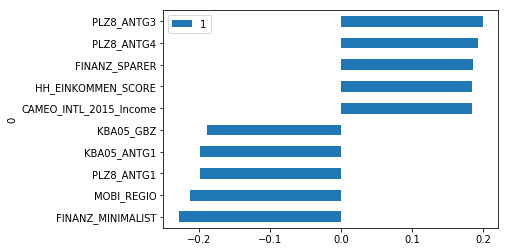

In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def featurefromcomponentAnalysis(componentvector, listcolumns,compNumber):
    return sorted([(col,comp) for col,comp in zip(listcolumns,componentvector[compNumber])],key=lambda x: x[1])

resultsFirst = featurefromcomponentAnalysis(mypca.components_,azdias_clean.columns,0)
tmpdf = pd.DataFrame(resultsFirst[0:5] + resultsFirst[-5:])#.plot(kind='barh')
tmpdf =tmpdf.set_index(tmpdf[0]).drop(columns=0)
tmpdf.plot(kind='barh')

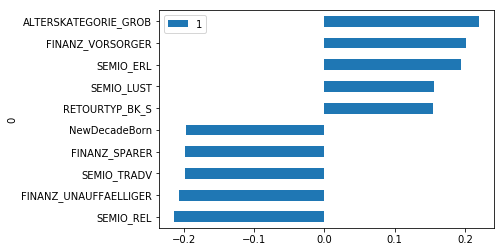

In [55]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
resultsSecond = featurefromcomponentAnalysis(mypca.components_,azdias_clean.columns,1)
tmpdf = pd.DataFrame(resultsSecond[0:5] + resultsSecond[-5:])#.plot(kind='barh')
tmpdf =tmpdf.set_index(tmpdf[0]).drop(columns=0)
tmpdf.plot(kind='barh')

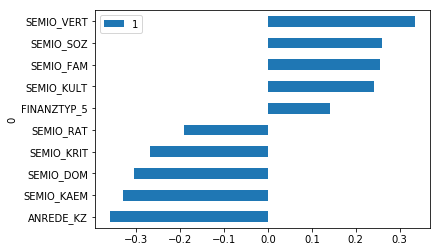

In [56]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
resultsThird = featurefromcomponentAnalysis(mypca.components_,azdias_clean.columns,2)
tmpdf = pd.DataFrame(resultsThird[0:5] + resultsThird[-5:])#.plot(kind='barh')
tmpdf =tmpdf.set_index(tmpdf[0]).drop(columns=0)
tmpdf.plot(kind='barh')

### Discussion 2.3: Interpret Principal Components

Above I tried displaying the 5 most important features that are negatively correlated with the principal component and also the 5 most important features that are positively correlated. This was repeated for the three first principal components, or the three components that explain most of the variance in the original dataset. This for example could be used for feature selection on the original dataset.

Based on the most relevant features for the first principal component, it can be said that this component categorizes people with low income and low savings that live in blocks rather than houses and with a profile of high movement

The second principal component is to do with age of the people and some personality traits. Personality wise, it prefers religious and traditional over event oriented individuals. As far as age, I would say that it is positively correlated with age so classifying older people

The third component is almost exclusively related to personality traits. Seems it favours active, social and family people over aggresive, critical or dominant minded.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [57]:

# Over a number of different cluster counts...
results = []
# Append results in a list to ease plotting in the following cell
if 1:
    for nclusters in range(2,15):
        print(nclusters)
        myclustering = KMeans(n_clusters=nclusters)
        # run k-means clustering on the data and...
        myclustering.fit(azdias_pcaed)

        # compute the average within-cluster distances.
        results.append(myclustering.score(azdias_pcaed)*-1)
    


2
3
4
5
6
7
8
9
10
11
12
13
14


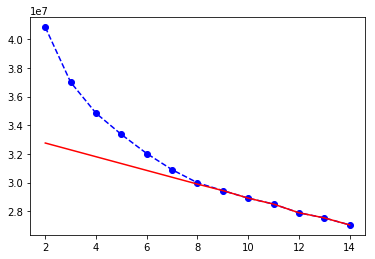

In [99]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
if 1:
    plt.plot(list(range(2,15)),results,linestyle='--', marker='o', color='b')
    plt.plot()
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X=np.asarray([[9,10,11,12,13,14]]).reshape(6,1), y=results[7:14])
predicted =model.predict(np.asarray(range(2,9)).reshape(-1,1))
plt.plot(list(range(2,15)),np.asarray(list(predicted.reshape(-1,1)) + list(results[7:14])),'r')

In [45]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# Given the graph above the elbow seems to be at k=8 clusters
myclustering = KMeans(n_clusters=8)
myclustering.fit(azdias_pcaed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [46]:
# Get a few predictions to check that it works
myclustering.predict(azdias_pcaed[100:107,:])

array([2, 2, 4, 0, 5, 6, 2], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

We have analysed the score for a few cluster sizes for the algorithm kmeans. The plot above where there is a red and a blue line seems to suggest that the elbow is at k = 8 clusters and so it's been decided to take 8 as the number of clusters in our analysis

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [47]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers, feat_info,['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'])
customers_clean = scaler.transform(customers_clean)
customers_clean = mypca.transform(customers_clean)
customers_clusters = myclustering.predict(customers_clean)

['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [48]:
list(customers_clusters)

[5,
 7,
 5,
 2,
 5,
 5,
 5,
 3,
 5,
 5,
 5,
 5,
 3,
 5,
 5,
 5,
 1,
 7,
 5,
 2,
 7,
 2,
 7,
 7,
 7,
 5,
 3,
 3,
 7,
 5,
 3,
 5,
 5,
 5,
 7,
 5,
 2,
 7,
 6,
 6,
 7,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 7,
 6,
 7,
 5,
 7,
 5,
 5,
 3,
 5,
 5,
 5,
 5,
 5,
 5,
 2,
 1,
 5,
 5,
 0,
 5,
 7,
 3,
 5,
 2,
 5,
 2,
 3,
 7,
 7,
 7,
 5,
 5,
 3,
 7,
 2,
 2,
 7,
 7,
 6,
 2,
 5,
 2,
 5,
 5,
 4,
 5,
 5,
 5,
 6,
 5,
 1,
 7,
 7,
 7,
 5,
 7,
 5,
 5,
 2,
 7,
 2,
 7,
 5,
 5,
 5,
 5,
 2,
 5,
 5,
 7,
 5,
 5,
 3,
 7,
 2,
 2,
 5,
 5,
 5,
 5,
 5,
 2,
 3,
 5,
 5,
 5,
 7,
 7,
 7,
 2,
 0,
 5,
 5,
 5,
 5,
 3,
 5,
 5,
 6,
 2,
 2,
 6,
 2,
 5,
 3,
 5,
 5,
 5,
 5,
 7,
 5,
 3,
 7,
 5,
 5,
 5,
 7,
 5,
 5,
 5,
 5,
 5,
 5,
 1,
 7,
 5,
 7,
 6,
 3,
 5,
 6,
 2,
 5,
 5,
 7,
 2,
 5,
 3,
 2,
 5,
 5,
 7,
 5,
 2,
 7,
 7,
 5,
 7,
 0,
 7,
 5,
 2,
 3,
 3,
 5,
 6,
 5,
 5,
 5,
 5,
 2,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 7,
 6,
 5,
 7,
 7,
 2,
 5,
 2,
 2,
 2,
 5,
 2,
 7,
 5,
 5,
 5,
 2,
 6,
 5,
 7,
 5,
 2,
 0,
 5,
 3,
 3,
 3,
 5,
 7,
 7,
 5,
 0,


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'Customer proportions per cluster')

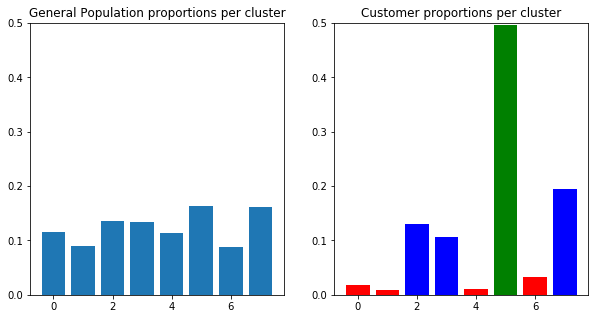

In [52]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# predict clusters for all individuals in the general population
predict_generalpop = myclustering.predict(azdias_pcaed)
predict_generalpop.shape, customers_clusters.shape
# create a dataframe to use pandas methods
generalpop = pd.DataFrame(predict_generalpop)
# get each cluster's proportion
generalpopProportions = generalpop[0].value_counts()/generalpop.shape[0]
# Do similarly for the customer dataset
customerbase = pd.DataFrame(customers_clusters)
customerProportions = customerbase[0].value_counts()/customerbase.shape[0]
# Sort the dataframes using the index
customerProportions = customerProportions.sort_index()
generalpopProportions = generalpopProportions.sort_index()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(x=generalpopProportions.index,height=np.asarray(generalpopProportions))
xmin,xmax,ymin,ymax = plt.axis()
plt.axis([xmin,xmax,0,0.5])
plt.title('General Population proportions per cluster')
plt.subplot(1,2,2)
plt.bar(x=customerProportions.index,height=np.asarray(customerProportions),color=['r','r','b','b','r','g','r','b'])
plt.axis([xmin,xmax,0,0.5])
plt.title('Customer proportions per cluster')

In [53]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
overrepresentedCluster = 5
genpop = pd.DataFrame(predict_generalpop)
azdias_clean[predict_generalpop==overrepresentedCluster]
#- FINANZ_MINIMALIST, MOBI_REGIO
# + 'PLZ8_ANTG3' PLZ8_ANTG4, CAMEO_INTL_2015_Income
#  - 'SEMIO_REL', 'FINANZ_UNAUFFAELLIGER', 'NewDecadeBorn'
#  + ALTERKATEGORIE_GROB FINANZ_VORSORGER
listPosCorr = ['PLZ8_ANTG3','PLZ8_ANTG4','CAMEO_INTL_2015_Income','ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER']
listNegCorre = ['FINANZ_MINIMALIST', 'MOBI_REGIO','SEMIO_REL', 'FINANZ_UNAUFFAELLIGER', 'NewDecadeBorn' ]
print('Features with positive correlation')
print('PLZ8_ANTG3')
print(azdias_clean[predict_generalpop==overrepresentedCluster][listPosCorr].loc[:,'PLZ8_ANTG3'].value_counts())
print('PLZ8_ANTG4')
print(azdias_clean[predict_generalpop==overrepresentedCluster][listPosCorr].loc[:,'PLZ8_ANTG4'].value_counts())
print('CAMEO_INTL_2015_Income')
print(azdias_clean[predict_generalpop==overrepresentedCluster][listPosCorr].loc[:,'CAMEO_INTL_2015_Income'].value_counts())
print('ALTERSKATEGORIE_GROB')
print(azdias_clean[predict_generalpop==overrepresentedCluster][listPosCorr].loc[:,'ALTERSKATEGORIE_GROB'].value_counts())
print('FINANZ_VORSORGER')
print(azdias_clean[predict_generalpop==overrepresentedCluster][listPosCorr].loc[:,'FINANZ_VORSORGER'].value_counts())
print('\n')

print('Features with negative correlation')
print('FINANZ_MINIMALIST')
print(azdias_clean[predict_generalpop==overrepresentedCluster][listNegCorre].loc[:,'FINANZ_MINIMALIST'].value_counts())
print('MOBI_REGIO')
print(azdias_clean[predict_generalpop==overrepresentedCluster][listNegCorre].loc[:,'MOBI_REGIO'].value_counts())
print('SEMIO_REL')
print(azdias_clean[predict_generalpop==overrepresentedCluster][listNegCorre].loc[:,'SEMIO_REL'].value_counts())
print('FINANZ_UNAUFFAELLIGER')
print(azdias_clean[predict_generalpop==overrepresentedCluster][listNegCorre].loc[:,'FINANZ_UNAUFFAELLIGER'].value_counts())
print('NewDecadeBorn')
print(azdias_clean[predict_generalpop==overrepresentedCluster][listNegCorre].loc[:,'NewDecadeBorn'].value_counts())
print('\n')


Features with positive correlation
PLZ8_ANTG3
1.0    62498
0.0    37309
2.0    26402
3.0      943
Name: PLZ8_ANTG3, dtype: int64
PLZ8_ANTG4
0.0    97214
1.0    29403
2.0      535
Name: PLZ8_ANTG4, dtype: int64
CAMEO_INTL_2015_Income
2.0    50613
1.0    35945
4.0    22910
3.0    11198
5.0     6486
Name: CAMEO_INTL_2015_Income, dtype: int64
ALTERSKATEGORIE_GROB
4.0    63024
3.0    61289
2.0     1681
1.0     1158
Name: ALTERSKATEGORIE_GROB, dtype: int64
FINANZ_VORSORGER
5    65206
4    45295
3    15642
2      517
1      492
Name: FINANZ_VORSORGER, dtype: int64


Features with negative correlation
FINANZ_MINIMALIST
5    89498
4    27599
3     9869
2      149
1       37
Name: FINANZ_MINIMALIST, dtype: int64
MOBI_REGIO
5.0    50162
4.0    45104
3.0    24886
2.0     5134
1.0     1748
6.0      118
Name: MOBI_REGIO, dtype: int64
SEMIO_REL
4    64208
3    29904
5    16045
2    13859
7     1800
6     1336
Name: SEMIO_REL, dtype: int64
FINANZ_UNAUFFAELLIGER
1    51863
2    48492
3    24307
4     1

In [54]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underrepresentedCluster = 4
genpop = pd.DataFrame(predict_generalpop)
azdias_clean[predict_generalpop==underrepresentedCluster]
#- FINANZ_MINIMALIST, MOBI_REGIO
# + 'PLZ8_ANTG3' PLZ8_ANTG4, CAMEO_INTL_2015_Income
#  - 'SEMIO_REL', 'FINANZ_UNAUFFAELLIGER', 'NewDecadeBorn'
#  + ALTERKATEGORIE_GROB FINANZ_VORSORGER
listPosCorr = ['PLZ8_ANTG3','PLZ8_ANTG4','CAMEO_INTL_2015_Income','ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER']
listNegCorre = ['FINANZ_MINIMALIST', 'MOBI_REGIO','SEMIO_REL', 'FINANZ_UNAUFFAELLIGER', 'NewDecadeBorn' ]
print('Features with positive correlation')
print('PLZ8_ANTG3')
print(azdias_clean[predict_generalpop==underrepresentedCluster][listPosCorr].loc[:,'PLZ8_ANTG3'].value_counts())
print('PLZ8_ANTG4')
print(azdias_clean[predict_generalpop==underrepresentedCluster][listPosCorr].loc[:,'PLZ8_ANTG4'].value_counts())
print('CAMEO_INTL_2015_Income')
print(azdias_clean[predict_generalpop==underrepresentedCluster][listPosCorr].loc[:,'CAMEO_INTL_2015_Income'].value_counts())
print('ALTERSKATEGORIE_GROB')
print(azdias_clean[predict_generalpop==underrepresentedCluster][listPosCorr].loc[:,'ALTERSKATEGORIE_GROB'].value_counts())
print('FINANZ_VORSORGER')
print(azdias_clean[predict_generalpop==underrepresentedCluster][listPosCorr].loc[:,'FINANZ_VORSORGER'].value_counts())
print('\n')

print('Features with negative correlation')
print('FINANZ_MINIMALIST')
print(azdias_clean[predict_generalpop==underrepresentedCluster][listNegCorre].loc[:,'FINANZ_MINIMALIST'].value_counts())
print('MOBI_REGIO')
print(azdias_clean[predict_generalpop==underrepresentedCluster][listNegCorre].loc[:,'MOBI_REGIO'].value_counts())
print('SEMIO_REL')
print(azdias_clean[predict_generalpop==underrepresentedCluster][listNegCorre].loc[:,'SEMIO_REL'].value_counts())
print('FINANZ_UNAUFFAELLIGER')
print(azdias_clean[predict_generalpop==underrepresentedCluster][listNegCorre].loc[:,'FINANZ_UNAUFFAELLIGER'].value_counts())
print('NewDecadeBorn')
print(azdias_clean[predict_generalpop==underrepresentedCluster][listNegCorre].loc[:,'NewDecadeBorn'].value_counts())
print('\n')



Features with positive correlation
PLZ8_ANTG3
3.0    41825
2.0    38572
1.0     6718
0.0      929
Name: PLZ8_ANTG3, dtype: int64
PLZ8_ANTG4
1.0    46470
2.0    32122
0.0     9452
Name: PLZ8_ANTG4, dtype: int64
CAMEO_INTL_2015_Income
5.0    50524
4.0    25427
3.0     6813
2.0     3849
1.0     1431
Name: CAMEO_INTL_2015_Income, dtype: int64
ALTERSKATEGORIE_GROB
2.0    34505
1.0    31786
3.0    21252
4.0      501
Name: ALTERSKATEGORIE_GROB, dtype: int64
FINANZ_VORSORGER
2    30839
3    25326
1    24038
4     6224
5     1617
Name: FINANZ_VORSORGER, dtype: int64


Features with negative correlation
FINANZ_MINIMALIST
1    71709
2    13266
3     2569
4      462
5       38
Name: FINANZ_MINIMALIST, dtype: int64
MOBI_REGIO
1.0    39818
2.0    30748
3.0    14959
4.0     2047
5.0      468
6.0        4
Name: MOBI_REGIO, dtype: int64
SEMIO_REL
7    42161
5    22142
4    15385
3     6554
1     1662
2      140
Name: SEMIO_REL, dtype: int64
FINANZ_UNAUFFAELLIGER
4    29497
5    25608
3    22918
2     6

### Discussion 3.3: Compare Customer Data to Demographics Data

Basically the idea is to estimate the clusters for individuals among the general population and also get the cluster for customers.
Then calculate the weight that each cluster weight as a ratio of the whole. Even though the analysis done in 1.1.3 showed differences between those rows that contained many features empty, those rows were removed and so they were not count towards the ratio and so that particular remark can be neglected for this solution
It can be seen below, that there are three clusters that are repesented in a similar way as the general population, four clusters that are underrepresented and only one cluster that we can clearly say it's overrepresented.
Cluster number 4 in this case represents 50% of the customers compared to 15-20% in the general population.

In order to find out what kind of people are those included in cluster 4, I went back to section 2.3 and took the 5 positively correlated features from the first two principal compoents. Also took the 5 negatively correlated features.
The counts for each value in those features are listed and this allows me to find out more about what kind of person each cluster represents.
For example people in cluster 4 are associated with the following:
+ PLZ8_ANTG3 -> 1 
+ PLZ8_ANTG4 -> 0 These last two means that individuals in cluster 4 live in an area with few family homes
+ CAMEO_INTL_2015_Income -> 2, 1 These means that customers are upper middle class or high class
+ ALTERKATEGORIE_GROS -> 4, 3 Based on name analysis customers are >46 years

- FINANZ_MINIMALIST -> 5 Based on this customers are financially saavy
- MOBI_REGIO -> 5,4 Low or very low movement
- SEMIO_REL -> 1, 2 and very religious
- FINANZ_UNAUFFAELLIGER -> 1, 2 very inconspicuous with their financial matters
- NewDecadeBorn -> 3, 2 customers born in the 60s and 70s so confirming >46

So overall, the customer is a middle age or older individual that belongs to upper middle class and are financially saavy and inconspicuous. Customers are very low movement and live in areas with a few family homes

In contrast
+ PLZ8_ANTG3 -> 3
+ PLZ8_ANTG4 -> 1 These two means that individuals in cluster 2 live in areas with bigger families
+ CAMEO_INTL_2015_Income -> 5 These means that customers are from poorer households
+ ALTERKATEGORIE_GROS -> 2, 1 Mainly in their 30s

- FINANZ_MINIMALIST -> 2,1 Also very high contrast here between cluster 4 and 2. they don't have much financial interest
- MOBI_REGIO -> 1,2 These people unfortunately are very high movement individuals
- SEMIO_REL -> 7, 6 and not religious at all
- FINANZ_UNAUFFAELLIGER -> 4, 5 again big contrast here
- NewDecadeBorn -> 5 customers born in the 80s and 90s

It's very clear that these two clusters represent very different people. Cluster 2 represent a type of person that it's not the typical customer for this customer.
They are mainly young between 25-35 and are not in a privilege position financially. They tend to struggle financially and not being very well educated in financial matters.
Places where they live are also different so it's their attitude towards faith.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.